# Policy learning

Based on: Gili Karni's
https://medium.com/swlh/policy-gradient-reinforcement-learning-with-keras-57ca6ed32555

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gym

from IPython.display import clear_output

import tensorflow as tf
# Some times this helps improving speed
tf.compat.v1.disable_eager_execution()

from tensorflow.python.keras.layers import Dense, Dropout
from tensorflow.python.keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.python.keras.models import load_model

from os import path

2021-10-28 13:28:06.833136: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
## Config ##
ENV="CartPole-v1"
RANDOM_SEED=1
N_EPISODES=1000
FILENAME='cartpole.h5'


# random seed (reproduciblity)
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

# set the env
env=gym.make(ENV) # env to import
env.seed(RANDOM_SEED)
env.reset() # reset to env 

array([ 0.03073904,  0.00145001, -0.03088818, -0.03131252])

Implement the REINFORCE agent class

In [3]:
class REINFORCE:
    
    def __init__(self, env, path=None):
        self.env=env #import env
        self.state_shape=env.observation_space.shape # the state space
        self.action_shape=env.action_space.n # the action space
        self.gamma=0.99 # decay rate of past observations
        self.alpha=1e-4 # learning rate in the policy gradient
        self.learning_rate=0.01 # learning rate in deep learning

        if not path:
          self.model=self._create_model() #build model
        else:
          self.model=self.load_model(path) #import model

        # record observations
        self.states=[]
        self.gradients=[] 
        self.rewards=[]
        self.probs=[]
        self.discounted_rewards=[]
        self.total_rewards=[]
  

    def _create_model(self):
        ''' builds the model using keras'''
        model=Sequential()

        # input shape is of observations
        model.add(Dense(24, input_shape=self.state_shape, activation="relu"))
        # model.add(Dropout(0.05))
        model.add(Dense(24, input_shape=self.state_shape, activation="relu"))
        # model.add(Dropout(0.05))
        model.add(Dense(12, activation="relu"))
        # model.add(Dropout(0.5))    

        # output shape is according to the number of action
        # The softmax function outputs a probability distribution over the actions
        model.add(Dense(self.action_shape, activation="softmax")) 
        model.compile(loss="categorical_crossentropy",
                optimizer=Adam(lr=self.learning_rate))

        return model

    
    def hot_encode_action(self, action):
        '''encoding the actions into a binary list'''

        action_encoded=np.zeros(self.action_shape, np.float32)
        action_encoded[action]=1

        return action_encoded
  

    def remember(self, state, action, action_prob, reward):
        '''stores observations'''
        encoded_action=self.hot_encode_action(action)
        self.gradients.append(encoded_action-action_prob)
        self.states.append(state)
        self.rewards.append(reward)
        self.probs.append(action_prob)

  
    def get_action(self, state):
        '''samples the next action based on the policy probabilty distribution 
          of the actions'''

        # transform state
        state=state.reshape([1, state.shape[0]])
        # get action probably
        action_probability_distribution=self.model.predict(state).flatten()
        # norm action probability distribution
        action_probability_distribution/=np.sum(action_probability_distribution)

        # sample action
        action=np.random.choice(self.action_shape,1,
                                p=action_probability_distribution)[0]

        return action, action_probability_distribution


    def get_discounted_rewards(self, rewards): 
        '''Use gamma to calculate the total reward discounting for rewards
        Following - \gamma ^ t * Gt'''

        discounted_rewards=[]
        cumulative_total_return=0
        # iterate the rewards backwards and and calc the total return 
        for reward in rewards[::-1]:      
          cumulative_total_return=(cumulative_total_return*self.gamma)+reward
          discounted_rewards.insert(0, cumulative_total_return)

        # normalize discounted rewards
        mean_rewards=np.mean(discounted_rewards)
        std_rewards=np.std(discounted_rewards)
        norm_discounted_rewards=(discounted_rewards-
                                 mean_rewards)/(std_rewards+1e-7) # avoiding zero div

        return norm_discounted_rewards

    
    def update_policy(self):
        '''Updates the policy network using the NN model.
        This function is used after the MC sampling is done - following
        \delta \theta = \alpha * gradient + log pi'''

        # get X
        states=np.vstack(self.states)

        # get Y
        gradients=np.vstack(self.gradients)
        rewards=np.vstack(self.rewards)
        discounted_rewards=self.get_discounted_rewards(rewards)
        gradients*=discounted_rewards
        gradients=self.alpha*np.vstack([gradients])+self.probs

        history=self.model.train_on_batch(states, gradients)

        self.states, self.probs, self.gradients, self.rewards=[], [], [], []

        return history

    
    def train(self, episodes, rollout_n=1, render_n=50):
        '''train the model
            episodes - number of training iterations 
            rollout_n- number of episodes between policy update
            render_n - number of episodes between env rendering ''' 

        env=self.env
        total_rewards=np.zeros(episodes)

        for episode in range(episodes):
            clear_output(wait=True)
            print("Episode:",episode)
            # each episode is a new game env
            state=env.reset()
            done=False          
            episode_reward=0 #record episode reward

            while not done:
                # play an action and record the game state & reward per episode
                action, prob=self.get_action(state)
                next_state, reward, done, _=env.step(action)
                self.remember(state, action, prob, reward)
                state=next_state
                episode_reward+=reward

                if episode%render_n==0: ## render env to visualize.
                  env.render()

                if done:
                  # update policy 
                  if episode%rollout_n==0:
                    history=self.update_policy()
                    print("  loss: ",history)

            total_rewards[episode]=episode_reward

        self.total_rewards=total_rewards

        
    def save_model(self,path):
        '''saves the model // do after training'''
        self.model.save(path)
  

    def load_model(self, filename):
        '''loads a trained model from path'''
        
        if path.exists(filename):   
    
            print("Reading file '{0}'".format(filename))
            return load_model(filename)  #load_model from keras
        
        else:
            
            return self._create_model()

In [4]:
# Create agent and train the model
agent=REINFORCE(env,path=FILENAME)

agent.train(episodes=N_EPISODES, rollout_n=3, render_n=50)

agent.save_model(FILENAME)

Episode: 999
  loss:  0.075130396


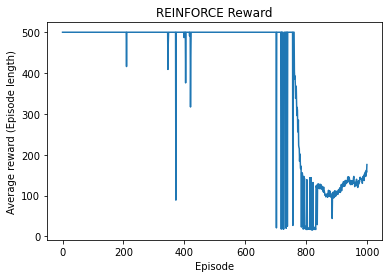

In [5]:
plt.title('REINFORCE Reward')
plt.xlabel('Episode')
plt.ylabel('Average reward (Episode length)')
plt.plot(agent.total_rewards)
plt.show()

In [6]:
## TODO:

## The reward should go up.  If it doesn't, fix it.
## Using the learned model, show episodes with the render method using it.